## Real Time Anomaly Detection in IOT Sensor Data

##### Showcasing real-time data ingestion leveraging SingleStore Pipelines 

##### Python Notebooks generating vector embeddings, using SQL for vector matching (dot_product) to flag anomaly.

###  Creating database and tables

#### Creating the database and tables in Singlestore for storing historical and real time data.

##### Once data from staging table is processed and loaded into historical table identifying anomalies

##### Metadata: date, city, longitude and latitude. 
##### Perameters: vent, pluie, temp for weather parameters. 
##### Anaomoly flag and embeddings column for storing vector embeddings.

In [20]:
%%sql
drop database IF EXISTS iot_sensor_db;

create database iot_sensor_db;

use iot_sensor_db;

CREATE TABLE sensor_data_with_vectors (
  date DATETIME,
    city VARCHAR(50),
    longitude VARCHAR(50),
    latitude VARCHAR(50),
  vent FLOAT(8,2),
  pluie FLOAT(8,2),
  temp FLOAT(8,2),
  anomaly VARCHAR(10),
  embeddings text
);

CREATE TABLE sensor_data_stage (
    city VARCHAR(50),
    longitude VARCHAR(50),
    latitude VARCHAR(50),
    vent FLOAT(8,2),
    pluie FLOAT(8,2),
    temp FLOAT(8,2),
    embeddings text,
    date DATETIME
);

++
||
++
++

### Lets create SingleStore Pipelines for fast data ingestion.

#### Loading historical data using S3 pipeline

In [20]:
%%sql

CREATE OR REPLACE PIPELINE sensor_data_pipeline AS
LOAD DATA S3 's3://real-time-anomaly-detection-demo/demothon/with_cities_embeddings.csv'
INTO TABLE `sensor_data_with_vectors`
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;

++
||
++
++

In [21]:
%%sql
start PIPELINE sensor_data_pipeline;

++
||
++
++

In [74]:
%%sql
SELECT COUNT(*) FROM sensor_data_with_vectors;

COUNT(*)
1051201


### Creating pipeline for realtime data ingestion

In [22]:
%%sql
CREATE OR REPLACE PIPELINE sensor_realtime_data_pipeline AS
LOAD DATA S3 's3://real-time-anomaly-detection-demo/demothon/demo_day_data2.csv'
INTO TABLE `sensor_data_stage`
(city, longitude, latitude, vent, pluie, temp, embeddings)
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\r\n'
IGNORE 1 LINES 
SET date = NOW();

++
||
++
++

In [23]:
%%sql
Start pipeline sensor_realtime_data_pipeline;

++
||
++
++

In [77]:
%%sql
SELECT COUNT(*) FROM sensor_data_stage

COUNT(*)
1440


### Preparing the data to be analysed

In [54]:
!pip install umap-learn --quiet

##### Note: Restart Kernel before importing umap 

In [17]:
import umap
from sklearn.preprocessing import normalize

##### In this step we would be removing incosistency from the data. 
##### We are handling 2 types of inconsistencies , removing junk values and backfilling missing values.


In [18]:
import sqlalchemy 
from sqlalchemy import create_engine
import json
import pandas as pd

In [85]:
# Filling null values usingbfill()

engine = create_engine(connection_url)

df = pd.read_sql('select * from sensor_data_stage', engine)

df = df.bfill(axis=0)

df = df.dropna()

### Generating Vector Embeddings using umap librabryusing umap librabry
##### Using three parameters vent, pluie and temp for creating feature vector. 
##### fit_transform reducer creates embedding from high dimentional space to low dimentional space.

In [93]:
# code to generate embeddings for real time data

new_df1 = df.iloc[50:100]
features = new_df1[['vent', 'pluie', 'temp']]

reducer = umap.UMAP(n_components=15)
embeddings = reducer.fit_transform(features)

In [94]:
normalized_embeddings = normalize(embeddings, norm='l2')
new_df1['embeddings'] = list(normalized_embeddings)

/tmp/ipykernel_162/2809028791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df1['embeddings'] = list(normalized_embeddings)


In [95]:
new_df1.head()

,city,longitude,latitude,vent,pluie,temp,embeddings,date
50,Washington DC,-77.0163,38.9047,26.62,18.19,23.32,"[0.3740911, 0.26156265, 0.29480088, 0.263396, ...",2023-12-04 17:54:39
51,Washington DC,-77.0163,38.9047,52.15,6.25,14.57,"[0.38509417, 0.23341164, 0.22573946, 0.2093660...",2023-12-04 17:54:39
52,Los Angeles,-118.4068,34.1141,31.24,17.21,25.72,"[0.3783063, 0.2595333, 0.29229397, 0.2641771, ...",2023-12-04 17:54:39
53,Los Angeles,-118.4068,34.1141,52.84,4.94,14.63,"[0.3855092, 0.23759565, 0.22717802, 0.21180171...",2023-12-04 17:54:39
54,Washington DC,-77.0163,38.9047,15.22,0.65,19.71,"[0.3611706, 0.27281713, 0.28869796, 0.236765, ...",2023-12-04 17:54:39


##### Once embeddings are generated we will use SingleStore dot_product function for flaging anomaly.

In [97]:
new_df = df.iloc[50:70].copy()
# iterate over each row in the new DataFrame
for index, row in new_df.iterrows():
    # get the embeddings from the current row
    embeddings = row['embeddings']
    
    # convert numpy array to list and then to a JSON string
    embeddings_json = json.loads(embeddings)

    # create the query string    
    query = f"""
           SELECT anomaly, COUNT(anomaly) as count 
            FROM (
                SELECT anomaly, dot_product(
                    JSON_ARRAY_PACK('{embeddings_json}'),
                    JSON_ARRAY_PACK(sensor_data_with_vectors.embeddings)
                ) AS similarity 
                FROM sensor_data_with_vectors 
                ORDER BY similarity DESC
                LIMIT 20
            ) AS subquery 
            GROUP BY anomaly 
            ORDER BY count DESC;
    """

    # execute the query
    result = pd.read_sql_query(query, con=engine)

    # check if the result is empty
    if not result.empty:
        # append the result to the current row in the new DataFrame
        new_df.loc[index, 'anomaly'] = result['anomaly'].values[0]
    else:
        # set anomaly to None or some default value
        new_df.loc[index, 'anomaly'] = 'none'

In [98]:
new_df.head()

,city,longitude,latitude,vent,pluie,temp,embeddings,date,anomaly
50,Washington DC,-77.0163,38.9047,26.62,18.19,23.32,"[0.3690796, 0.2825141, 0.3178044, 0.15740892, ...",2023-12-04 17:54:39,none
51,Washington DC,-77.0163,38.9047,52.15,6.25,14.57,"[0.45381021, 0.21210396, 0.09760296, 0.4123523...",2023-12-04 17:54:39,none
52,Los Angeles,-118.4068,34.1141,31.24,17.21,25.72,"[0.3679211, 0.28131846, 0.33997783, 0.16240497...",2023-12-04 17:54:39,none
53,Los Angeles,-118.4068,34.1141,52.84,4.94,14.63,"[0.45335296, 0.20799527, 0.100669265, 0.408407...",2023-12-04 17:54:39,none
54,Washington DC,-77.0163,38.9047,15.22,0.65,19.71,"[0.36964908, 0.23088546, 0.18799761, 0.1710868...",2023-12-04 17:54:39,none


##### Appending the historical table with stage table data

In [133]:
# appending the new dataframe to main the table : sensor_data_with_vectors
new_df['date'] = pd.to_datetime(new_df['date']) 
new_df['city'] = new_df['city'].astype(str)
new_df['longitude'] = new_df['longitude'].astype(str)
new_df['latitude'] = new_df['latitude'].astype(str)
new_df['vent'] = new_df['vent'].astype(float)
new_df['pluie'] = new_df['pluie'].astype(float)
new_df['temp'] = new_df['temp'].astype(float)
new_df['anomaly'] = new_df['anomaly'].astype(str)
new_df['embeddings'] = new_df['embeddings'].astype(str)

# Append data to SQL table
new_df.to_sql('sensor_data_with_vectors', con=engine, if_exists='append', index=False)

20

### Dashboard for Anomalies over Time

In [134]:
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine
engine = create_engine(connection_url)

In [137]:
# df = pd.read_sql('select * from sensor_data_with_vectors limit 50000;', engine)
df = pd.read_sql("select * from sensor_data_with_vectors where anomaly <> 'none' limit 50000;", engine)

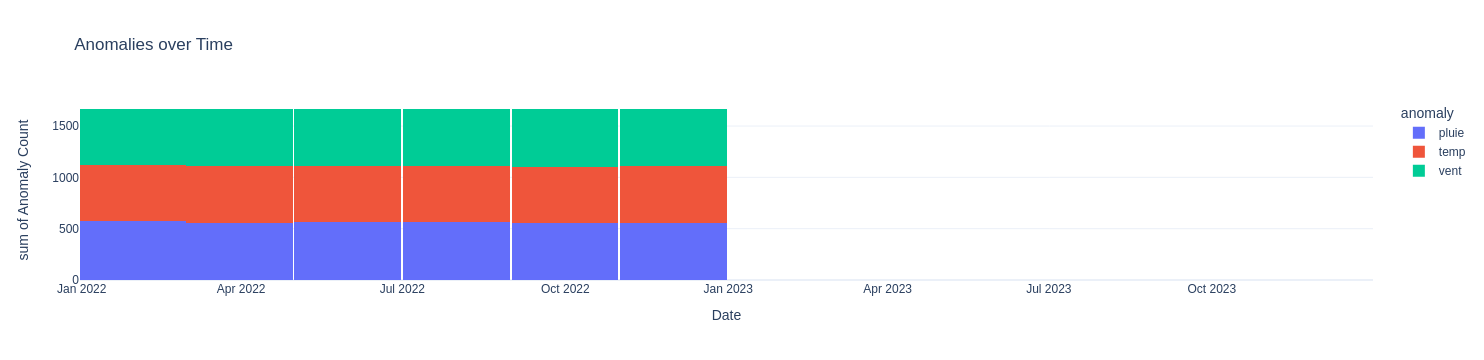

In [138]:
df['date'] = pd.to_datetime(df['date']) 
df['date_only'] = df['date'].dt.date
# Group data by date and anomaly, then count the instances
grouped_df = df.groupby(['date_only', 'anomaly']).size().reset_index(name='counts')

# Create line plot with Plotly
fig = px.histogram(grouped_df, x='date_only', y='counts', color='anomaly', 
              title='Anomalies over Time', labels={'date_only': 'Date', 'counts': 'Anomaly Count'})

# Show plot
fig.show()

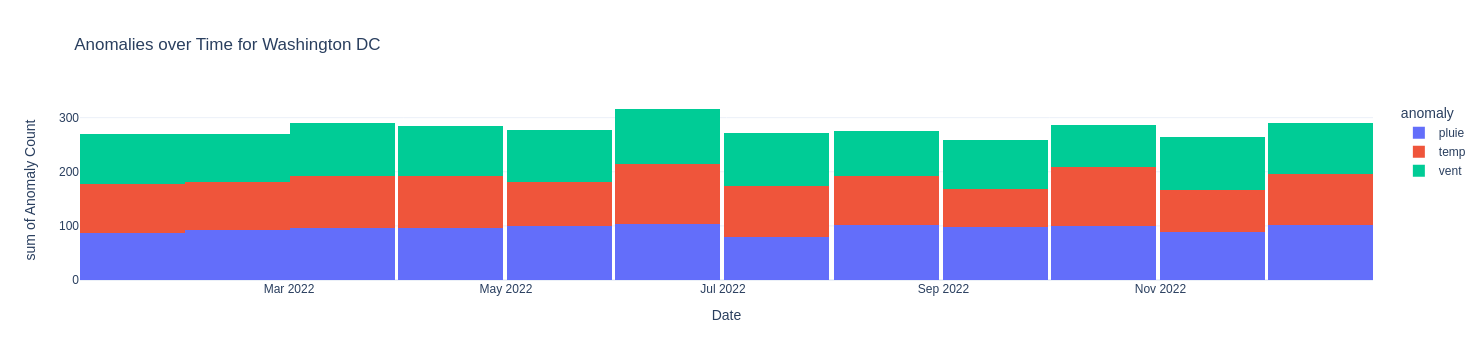

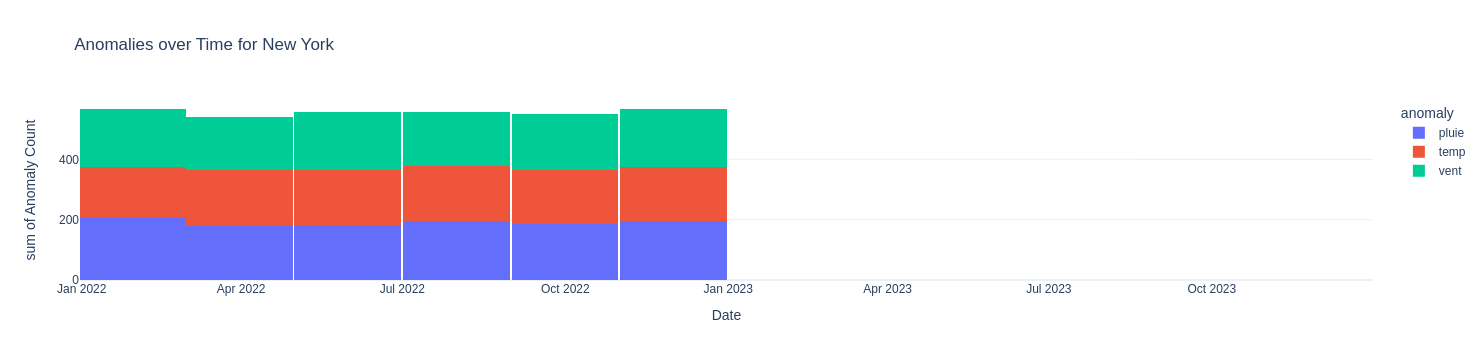

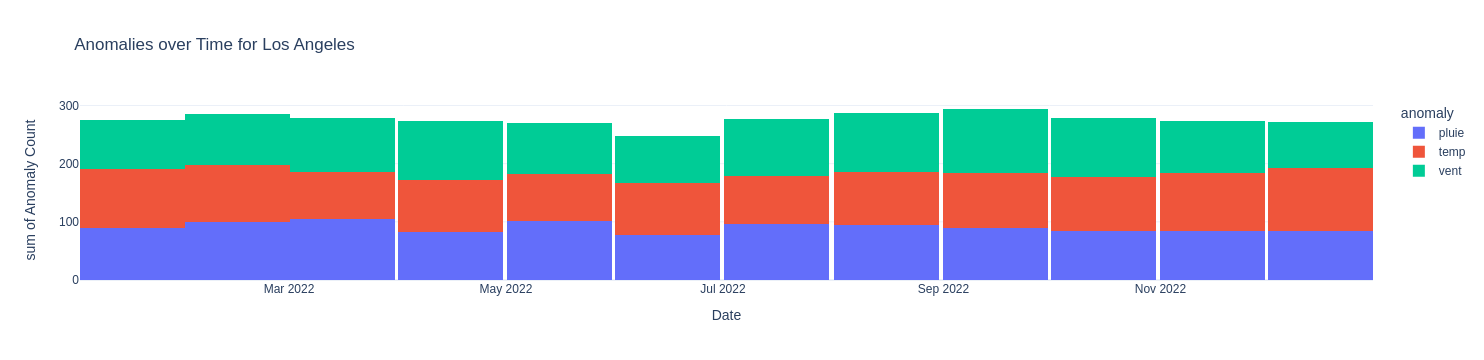

In [16]:
# Group data by date, city and anomaly, then count the instances
grouped_df = df.groupby(['date_only', 'city', 'anomaly']).size().reset_index(name='counts')

# List your cities
cities = ['Washington DC', 'New York', 'Los Angeles'] # Add or change according to your DataFrame

# Create a separate plot for each city
for city in cities:
    city_df = grouped_df[grouped_df['city'] == city]
    fig = px.histogram(city_df, x='date_only', y='counts', color='anomaly',
                  title=f'Anomalies over Time for {city}', labels={'date_only': 'Date', 'counts': 'Anomaly Count'})
    fig.show()

### Real Time Anomaly Detection Dashboard

In [99]:
!pip install tabulate pymysql Ipython rich --quiet

In [100]:
import time
import os
import shutil
import pymysql
from rich.console import Console
from rich.table import Table
from rich import box
from IPython.display import clear_output

In [101]:
from sqlalchemy import create_engine
import pandas as pd

def display_table_contents():
    # Create a database engine
    engine = create_engine(connection_url)

    # Execute query to fetch initial table contents
    query = 'SELECT date, vent, pluie, temp, anomaly FROM sensor_data_with_vectors ORDER BY date DESC'
    table_data = pd.read_sql_query(query, engine)

    while True:
        # Clear console output
        clear_output(wait=True)

        # Create a console instance
        console = Console()

        # Get the terminal width
        terminal_width = shutil.get_terminal_size().columns

        # Print the title with centered alignment
        title = "[bold magenta]REAL TIME ANALYTICS DASHBOARD[/bold magenta]"
        console.print(title.center(terminal_width))

        # Create a table instance
        table = Table(show_header=True, header_style="bold", box=None)

        # Add columns to the table
        table.add_column("Date", justify="center", style="cyan", width=terminal_width // 5 + 5)
        table.add_column("Vent", justify="center", style="magenta", width=terminal_width // 5)
        table.add_column("Pluie", justify="center", style="yellow", width=terminal_width // 5)
        table.add_column("Temp", justify="center", style="green", width=terminal_width // 5)
        table.add_column("Anomaly", justify="center", width=terminal_width // 5)

        # Add rows to the table
        for row in table_data.head(50).itertuples(index=False):
            # Convert datetime to string before adding to the table
            formatted_row = [str(cell) for cell in row]

            # Check the anomaly type
            anomaly_type = formatted_row[4]

            # Determine the style based on the anomaly type
            if anomaly_type == 'pluie':
                style = "bold blue"
            elif anomaly_type == 'vent':
                style = "bold magenta"
            elif anomaly_type == 'temp':
                style = "bold green"
            else:
                style = ""

            # Add the row with the appropriate style
            table.add_row(*formatted_row, style=style)

        # Print the table
        console.print(table)

        # Wait for 30 seconds before refreshing
        time.sleep(10)

        # Execute query to fetch updated table contents
        updated_data = pd.read_sql_query(query, engine)

        # Update the table_data with the fetched data
        table_data = updated_data

# Call the function to start displaying the table contents
display_table_contents()


REAL TIME ANALYTICS DASHBOARD

         Date                 Vent             Pluie              Temp            Anomaly      
  2023-01-01 00:00:00        12.23              2.87             14.84              none       
  2022-12-31 23:59:30        36.25             19.54              7.77              none       
  2022-12-31 23:59:00        59.93             17.01              13.4              none       
  2022-12-31 23:58:30        30.25             16.12             17.24              none       
  2022-12-31 23:58:00        46.55              0.84             25.08              none       
  2022-12-31 23:57:30        22.26              18.3             17.72              none       
  2022-12-31 23:57:00        59.15             15.75             20.19              none       
  2022-12-31 23:56:30        12.41              9.68             17.85              none       
  2022-12-31 23:56:00        52.76             18.59             23.06              none       
  2022-12-31 23:55:30         3.28             13.53              6.32              none       
  2022-12-31 23:55:00         1.47              6.26             14.59              none       
  2022-12-31 23:54:30        16.77              2.01              17.8              none       
  2022-12-31 23:54:00        58.44             14.45             15.26              none       
  2022-12-31 23:53:30        14.75              3.14              9.02              none       
  2022-12-31 23:53:00         0.24             18.39             17.47              none       
  2022-12-31 23:52:30        13.42             10.91             13.15              none       
  2022-12-31 23:52:00        26.89              6.48             28.64              none       
  2022-12-31 23:51:30        24.36              1.83              9.18              none       
  2022-12-31 23:51:00         7.56              11.6             25.99              none       
  2022-12-31 23:50:30        23.66              0.52             18.18              none       
  2022-12-31 23:50:00        57.02              4.78             18.98              none       
  2022-12-31 23:49:30         2.18             10.02             20.23              none       
  2022-12-31 23:49:00         0.19             18.98             13.04              none       
  2022-12-31 23:48:30        45.45             14.56              8.14              none       
  2022-12-31 23:48:00         4.39              4.63             27.65              none       
  2022-12-31 23:47:30        53.33              0.97             23.69              none       
  2022-12-31 23:47:00        53.43              5.03              6.49              none       
  2022-12-31 23:46:30        23.55             18.35             24.33              none       
  2022-12-31 23:46:00        16.27             15.88              18.9              none       
  2022-12-31 23:45:30        48.77              7.86             18.83              none       
  2022-12-31 23:45:00        53.27              8.94             16.31              none       
  2022-12-31 23:44:30         23.4             18.37             19.48              none       
  2022-12-31 23:44:00        31.11             15.17              28.0              none       
  2022-12-31 23:43:30        40.85              18.3             11.82              none       
  2022-12-31 23:43:00        43.78             10.78             14.57              none       
  2022-12-31 23:42:30        29.72             18.71              25.3              none       
  2022-12-31 23:42:00        42.23             11.98              6.51              none       
  2022-12-31 23:41:30        47.94              7.22              9.36              none       
  2022-12-31 23:41:00        10.48             17.43              7.64              none       
  2022-12-31 23:40:30         50.0             13.77             17.83              none       
  2022-12-31 23:40:00        39.75             17.84            

KeyboardInterrupt: 